## 2. Employing Keras on the single label testing set for Celeb-A dataset

1. Cleaning & creating dataset (We are only using the single label which is female).
2. Creating training and testing partition
3. Data Preprocessing
4. Creaing the Traning, Testing an Validation Sets
6. Train model performances

### (1) Cleaning and creating dataset 

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
from skimage import io
import cv2

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.models import Model

In [6]:
main_cd = "C:\\Users\\xil14\\Desktop\\Zora\\Machine Learning Projects\\Facial Recognition\\celeba-dataset\\"
img_cd=main_cd +"img_align_celeba\\img_align_celeba\\"
df_attr = pd.read_csv(main_cd + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [7]:
df_attr.columns

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

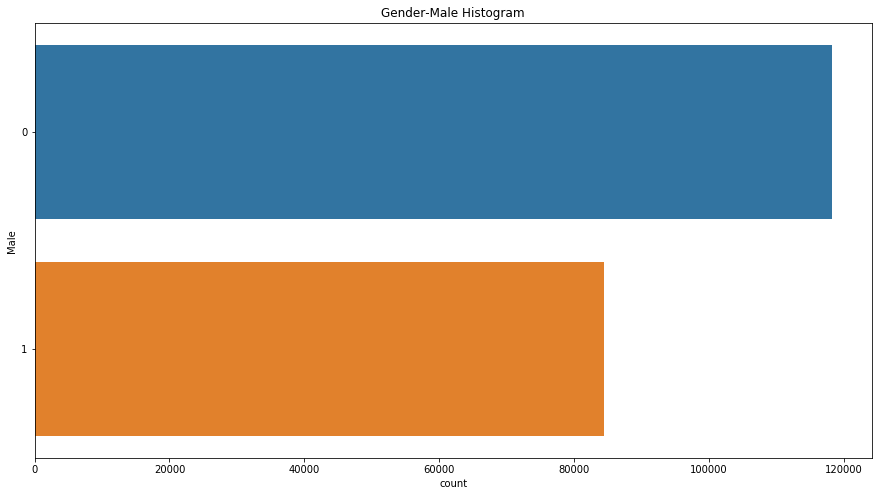

In [8]:
figure = plt.figure(figsize=(15,8))
plt.title('Gender-Male Histogram')
sns.countplot(y='Male', data=df_attr)
plt.show()

### (2) Training and testing split

The dataset provided the suggested training, validation and testing dataset partition. We will use that to divide our dataset

In [9]:
df_partition = pd.read_csv(main_cd + 'list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [10]:
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how = 'inner')

In [11]:
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [12]:
TRAINING_SAMPLES = 5000
VALIDATION_SAMPLES = 1000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 3

In [13]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(img_cd + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 224, 224, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(img_cd + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

### (2) Data Preprocessing

In the Data Preprocessing steps, we will be doing squaring, choping and padding to make the image to be uniformly 224x224x3 scale for further processing.

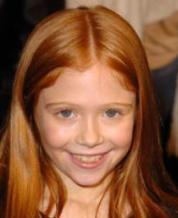

In [14]:
img2 = load_img(img_cd + '182640.jpg')
img2

In [15]:
import cv2
def extractFace(img, fc, tol):
    H,W,D = img.shape
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.array(gray, dtype='uint8')
    face_coords = fc.detectMultiScale(gray,1.2,tol,minSize=(60,60))
    
    if len(face_coords)==1:
        x,y,w,h = face_coords[0]
    elif len(face_coords)==0:
        return None
    else:
        max_area = 0
        index = 0
        for i in range(len(face_coords)):
            _,_,wi,hi = face_coords[i]
            area = wi*hi
            if area > max_area:
                max_area = area
                index = i
        x,y,w,h = face_coords[index]
    crop = img[y:y+w, x:x+h]
    
    return crop

fc = cv2.CascadeClassifier(main_cd + "haarcascade_frontalface_default.xml")

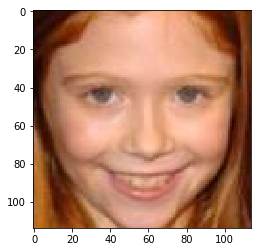

In [16]:
img2 = cv2.imread(img_cd + '182640.jpg')
crop2 = extractFace(img2,fc,20)
rgb2 = cv2.cvtColor(crop2,cv2.COLOR_BGR2RGB)
plt.imshow(rgb2)

In [17]:
def shaping(rgb):
    desired_size = 224
    im = rgb
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
    value=color)
    return(new)
new = shaping(rgb2)
new.shape

(224, 224, 3)

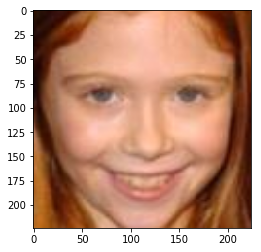

In [18]:
plt.imshow(new)

So we successfully change the size of the image. 

### (3) Preparing Traning and testing data

In [19]:
df_partition = pd.read_csv(main_cd + 'list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [20]:
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how = 'inner')

In [21]:
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [25]:
TRAINING_SAMPLES = 5000
VALIDATION_SAMPLES = 1000

## Training Dataset:


num_samples = TRAINING_SAMPLES
attr = 'Male'
df = df_par_attr[(df_par_attr['partition'] == 0) 
                    & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
df = pd.concat([df,df_par_attr[(df_par_attr['partition'] == 0) 
                    & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])


def df_generator(df):   
    x = np.array([])
    for fname in df.index:
        img = cv2.imread(img_cd + fname)
        crop = extractFace(img,fc,20)
        if crop is None:
            df = df.drop(fname)
        else:
            rgb = cv2.cvtColor(crop,cv2.COLOR_BGR2RGB)
            new_im = shaping(rgb)
            x = np.vstack([x, new_im]) if x.size else new_im
    x = x.reshape(int(x.shape[0]/224), 224, 224, 3)
    y = np_utils.to_categorical(df[attr],2)
    return x, y

x_train, y_train = df_generator(df)



In [26]:

## Validation Dataset:


num_samples = VALIDATION_SAMPLES
attr = 'Male'
df2 = df_par_attr[(df_par_attr['partition'] == 1) 
                    & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
df2 = pd.concat([df2,df_par_attr[(df_par_attr['partition'] == 1) 
                    & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

x_valid, y_valid = df_generator(df2)

### (4) Image-Augmentation 

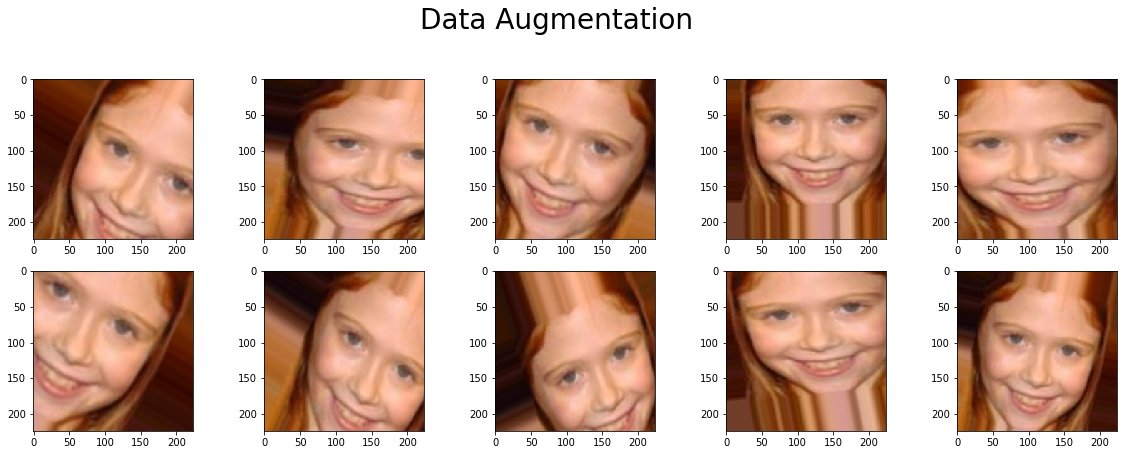

In [27]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
x = img_to_array(new)/255.
x = x.reshape((1,) + x.shape)
# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(224, 224, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

### (5) Model Building using Keras

lenet -> alexnet -> vgg -> resnet / inception

The lenet discussed in the MNIST data was initially designed to train on 28x28x1 input data, and LeNet-5 has 7 layers that specifically on MNIST dataset. Which means it is nearly impossible to train on other large scale dataset. 

[Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)


Alexnet also a very influential and powerful architecture and it is designed for Imagenet dataset which takes in 224x224x3 images. 


In [28]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 16
NUM_EPOCHS = 3

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

#### 1. VGG-16

VGG-19 is taking a longer time and it is not necessarily become more efficient.

In [29]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense,GlobalAveragePooling2D


import numpy as np

In [30]:
model_vgg16 = VGG16(weights='imagenet', include_top=False,input_shape = (224,224,3))

In [31]:
#Use the generated model 
x = model_vgg16.output

# #Add the fully-connected layers 
# x = Flatten(name='flatten')(output_vgg16_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
# x = Dense(2, activation='softmax', name='predictions')(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
predictions = Dense(2, activation = 'softmax')(x)

#Create your own model 
model2 = Model(input=model_vgg16.input, output=predictions)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
model2.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


In [36]:
train_n = x_train.shape[0]
model2.compile(optimizer = SGD(lr = 0.0001, momentum = 0.9), loss= "categorical_crossentropy", metrics = ['accuracy'])
checkpointer = ModelCheckpoint(filepath = 'weights.best.vgg16.male.hdf5', verbose=1, save_best_only=True)
hist2 = model2.fit_generator(train_generator, epochs=1,
                              validation_data=(x_valid, y_valid), verbose=1, steps_per_epoch= train_n/BATCH_SIZE,
                              callbacks=[checkpointer])

Epoch 1/1
 99/227 [============>.................] - ETA: 26:01 - loss: 8.0896 - acc: 0.4981

KeyboardInterrupt: 

####  2. VGG-19

In [37]:
from keras.applications.vgg19 import VGG19
model_vgg19 = VGG19(weights='imagenet', include_top=False,input_shape = (224,224,3))

In [38]:
#Use the generated model 
x = model_vgg19.output

# #Add the fully-connected layers 
# x = Flatten(name='flatten')(output_vgg16_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
# x = Dense(2, activation='softmax', name='predictions')(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
predictions = Dense(2, activation = 'softmax')(x)

#Create your own model 
model3 = Model(input=model_vgg19.input, output=predictions)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


In [ ]:
train_n = x_train.shape[0]
model3.compile(optimizer = SGD(lr = 0.0001, momentum = 0.9), loss= "categorical_crossentropy", metrics = ['accuracy'])
checkpointer = ModelCheckpoint(filepath = 'weights.best.vgg19.male.hdf5', verbose=1, save_best_only=True)
hist3 = model3.fit_generator(train_generator, epochs=1,
                              validation_data=(x_valid, y_valid), verbose=1, steps_per_epoch= train_n/BATCH_SIZE,
                              callbacks=[checkpointer])

#### 3. Inception v3






In [40]:
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.layers import GlobalAveragePooling2D
model_incv3 = InceptionV3(weights='imagenet', include_top=False,input_shape = (224,224,3))

In [41]:
#Use the generated model 
x = model_incv3.output
# #Add the fully-connected layers 
# x = Flatten(name='flatten')(output_vgg16_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
# x = Dense(2, activation='softmax', name='predictions')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation = 'softmax')(x)

#Create your own model 
model4 = Model(input=model_incv3.input, output=predictions)

for layer in model4.layers[:52]:
    layer.trainable = False

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
model4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


In [ ]:
train_n = x_train.shape[0]
model4.compile(optimizer = SGD(lr = 0.0001, momentum = 0.9), loss= "categorical_crossentropy", metrics = ['accuracy'])
checkpointer = ModelCheckpoint(filepath = 'weights.best.inc.male.hdf5', verbose=1)
hist4 = model4.fit_generator(train_generator, epochs=1,
                              validation_data=(x_valid, y_valid), verbose=1, steps_per_epoch= train_n/BATCH_SIZE,
                              callbacks=[checkpointer])

#### (4) ResNet -50

In [42]:
from keras.applications.resnet50 import ResNet50
model_resnet50 = ResNet50(weights = 'imagenet',include_top=False,input_shape = (224,224,3))

In [43]:
#Use the generated model 
x = model_resnet50.output
# #Add the fully-connected layers 
# x = Flatten(name='flatten')(output_vgg16_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
# x = Dense(2, activation='softmax', name='predictions')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation = 'softmax')(x)

#Create your own model 
model5 = Model(input=model_resnet50.input, output=predictions)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
model5.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


In [ ]:
train_n = x_train.shape[0]
model5.compile(optimizer = SGD(lr = 0.0001, momentum = 0.9), loss= "categorical_crossentropy", metrics = ['accuracy'])
checkpointer = ModelCheckpoint(filepath = 'weights.best.inc.male.hdf5', verbose=1)
hist5 = model5.fit_generator(train_generator, epochs=1,
                              validation_data=(x_valid, y_valid), verbose=1, steps_per_epoch= train_n/BATCH_SIZE,
                              callbacks=[checkpointer])